# 0. Overview

This project analyzes New York City yellow taxi trips in 2016 using the publicly available dataset from Google BigQuery:
bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016 (https://bigquery.cloud.google.com/dataset/bigquery-public-data:new_york).


The objective is to uncover patterns in ride behavior, evaluate driver earnings, and explore the impact of various factors—such as trip length, time of day, and weather—on taxi activity and tipping behavior.

We aim to answer the following five questions:

1. How does the number of taxi rides vary over time of day?

2. What types of trips are common?
  * Create your own definition of short, medium, and long trip
  * Show what percentage of rides fall into each category.

3. Are short or long trips better for drivers?
  * Compare how much money drivers earn from each type of trip.

4. Can the weather explain changes in taxi activity?
  * Try to find a connection between weather and the number of taxi rides.

5. How can drivers earn more tips?
  * Based on your analysis, what advice would you give a driver to help them increase their tips?

# 1. Data Loading


In [20]:
# Load data from bigquery
from google.cloud import bigquery
from google.colab import auth
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np

# Authenticate and initialize BigQuery client
auth.authenticate_user()
project_id = "pure-ivy-465314-k4"
client = bigquery.Client(project=project_id)

In [21]:
# Query taxi data (sample for January 2016)
query = """
SELECT
  pickup_datetime,
  dropoff_datetime,
  passenger_count,
  trip_distance,
  fare_amount,
  tip_amount,
  total_amount,
  payment_type,
  pickup_location_id,
  dropoff_location_id
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016`
WHERE pickup_datetime BETWEEN '2016-01-01' AND '2016-01-31'
  AND trip_distance > 0
  AND fare_amount > 0
LIMIT 100000
"""
df = client.query(query).to_dataframe()
df.head(5)

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,payment_type,pickup_location_id,dropoff_location_id
0,2016-01-27 13:47:46+00:00,2016-01-27 13:56:04+00:00,1,0.400000000,0.020000000,0E-9,0.820000000,2,237,237
1,2016-01-16 12:12:31+00:00,2016-01-16 12:13:37+00:00,1,1.500000000,2.000000000,0E-9,2.800000000,3,265,265
2,2016-01-15 21:18:35+00:00,2016-01-15 21:40:52+00:00,1,2.700000000,1.000000000,0E-9,1.300000000,2,125,265
3,2016-01-10 10:57:52+00:00,2016-01-10 11:54:07+00:00,2,29.600000000,1.000000000,0E-9,1.300000000,2,263,265
4,2016-01-18 14:36:46+00:00,2016-01-18 14:40:30+00:00,1,0.250000000,0.450000000,0E-9,1.250000000,2,138,138


# 2. Data Cleaning & Preprocessing

In [22]:
# Convert datetime fields
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

# Add derived features
df['hour'] = df['pickup_datetime'].dt.hour
df['weekday'] = df['pickup_datetime'].dt.day_name()
df['trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60

# Define trip categories
def categorize_trip(dist):
    if dist <= 2:
        return 'Short'
    elif dist <= 6:
        return 'Medium'
    else:
        return 'Long'
df['trip_type'] = df['trip_distance'].apply(categorize_trip)


In [23]:
df.head(5)

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,payment_type,pickup_location_id,dropoff_location_id,hour,weekday,trip_duration,trip_type
0,2016-01-27 13:47:46+00:00,2016-01-27 13:56:04+00:00,1,0.400000000,0.020000000,0E-9,0.820000000,2,237,237,13,Wednesday,8.300000,Short
1,2016-01-16 12:12:31+00:00,2016-01-16 12:13:37+00:00,1,1.500000000,2.000000000,0E-9,2.800000000,3,265,265,12,Saturday,1.100000,Short
2,2016-01-15 21:18:35+00:00,2016-01-15 21:40:52+00:00,1,2.700000000,1.000000000,0E-9,1.300000000,2,125,265,21,Friday,22.283333,Medium
3,2016-01-10 10:57:52+00:00,2016-01-10 11:54:07+00:00,2,29.600000000,1.000000000,0E-9,1.300000000,2,263,265,10,Sunday,56.250000,Long
4,2016-01-18 14:36:46+00:00,2016-01-18 14:40:30+00:00,1,0.250000000,0.450000000,0E-9,1.250000000,2,138,138,14,Monday,3.733333,Short


# 3. Exploratory Data Analysis & Questions


## Q1: How does the number of taxi rides vary over time of day?

In this section, we explore how taxi ride volume fluctuates throughout the day.
By aggregating the number of trips by hour (0–23), we aim to identify peak and off-peak periods of demand.


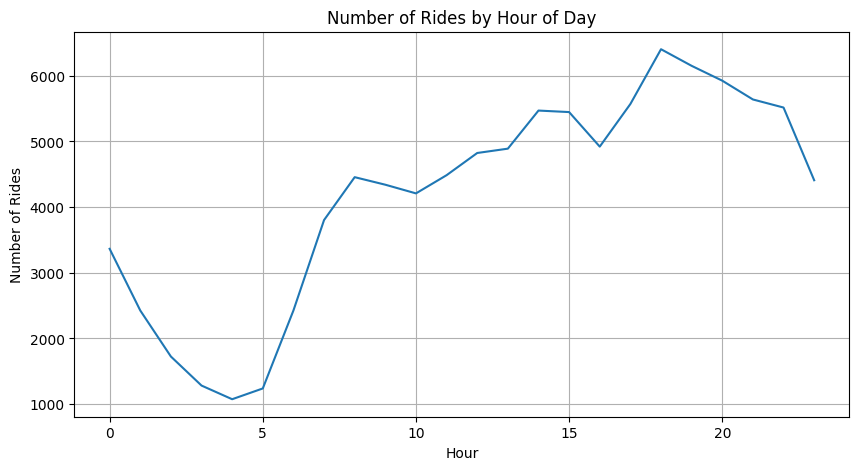

In [24]:
rides_by_hour = df.groupby('hour').size()
plt.figure(figsize=(10,5))
sns.lineplot(x=rides_by_hour.index, y=rides_by_hour.values)
plt.title('Number of Rides by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Rides')
plt.grid(True)
plt.show()

## Q2: What types of trips are common?

Based on the cleaned and processed data, trips are categorized by trip_distance into three types:

- Short trips: distance ≤ 2 miles

- Medium trips: distance between 2 and 6 miles

- Long trips: distance > 6 miles

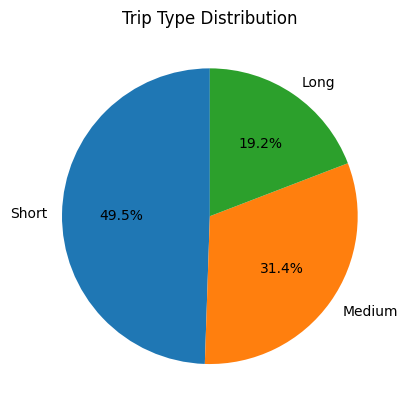

In [25]:
trip_type_counts = df['trip_type'].value_counts(normalize=True)
trip_type_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Trip Type Distribution')
plt.ylabel('')
plt.show()

## Q3: Are short or long trips better for drivers?

In [26]:
earnings_by_trip = df.groupby('trip_type')[['fare_amount', 'tip_amount', 'total_amount']].mean()
print(earnings_by_trip)

          fare_amount tip_amount total_amount
trip_type                                    
Long        45.102436   6.456824    56.168826
Medium      13.163426   1.793722    16.151764
Short         8.41139   1.070966    10.610104


## Q4: Can the weather explain changes in taxi activity?

In this section, We merged the taxi trip data with weather data to analyze how weather factors relate to taxi activity.

In [27]:
# Load daily taxi ride counts for 2016
query_rides_per_day = """
SELECT
  DATE(pickup_datetime) AS date,
  COUNT(*) AS num_rides
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016`
WHERE pickup_datetime BETWEEN '2016-01-01' AND '2016-12-31'
GROUP BY date
ORDER BY date
"""
rides_df = client.query(query_rides_per_day).to_dataframe()
rides_df.head()


,date,num_rides
0,2016-01-01,345036
1,2016-01-02,312830
2,2016-01-03,302878
3,2016-01-04,316008
4,2016-01-05,343128


In [28]:
# Load daily weather data (precipitation and max temperature) for 2016 from a specific weather station
query_weather = """
SELECT
  DATE(date) AS date,
  element,
  value
FROM `bigquery-public-data.ghcn_d.ghcnd_2016`
WHERE id = 'USW00094728'
  AND element IN ('PRCP', 'TMAX')
"""
weather_raw_df = client.query(query_weather).to_dataframe()
weather_raw_df.head()

,date,element,value
0,2016-03-03,TMAX,22.0
1,2016-03-17,PRCP,0.0
2,2016-03-19,TMAX,78.0
3,2016-10-19,TMAX,294.0
4,2016-10-22,TMAX,139.0


In [29]:
# Pivot weather data from long to wide format
weather_df = weather_raw_df.pivot(index='date', columns='element', values='value').reset_index()

# Unit conversion:
# PRCP (precipitation) is originally in tenths of millimeters -> convert to millimeters
# TMAX (max temperature) is originally in tenths of degrees Celsius -> convert to degrees Celsius
weather_df['PRCP'] = weather_df['PRCP'] / 10
weather_df['TMAX'] = weather_df['TMAX'] / 10
weather_df.head()

element,date,PRCP,TMAX
0,2016-01-01,0.0,5.6
1,2016-01-02,0.0,4.4
2,2016-01-03,0.0,7.2
3,2016-01-04,0.0,2.2
4,2016-01-05,0.0,-1.6


In [30]:
# Merge taxi rides and weather data on the date column (inner join to keep only matching dates)
combined_df = pd.merge(rides_df, weather_df, on='date', how='inner')
combined_df.head()

,date,num_rides,PRCP,TMAX
0,2016-01-01,345036,0.0,5.6
1,2016-01-02,312830,0.0,4.4
2,2016-01-03,302878,0.0,7.2
3,2016-01-04,316008,0.0,2.2
4,2016-01-05,343128,0.0,-1.6


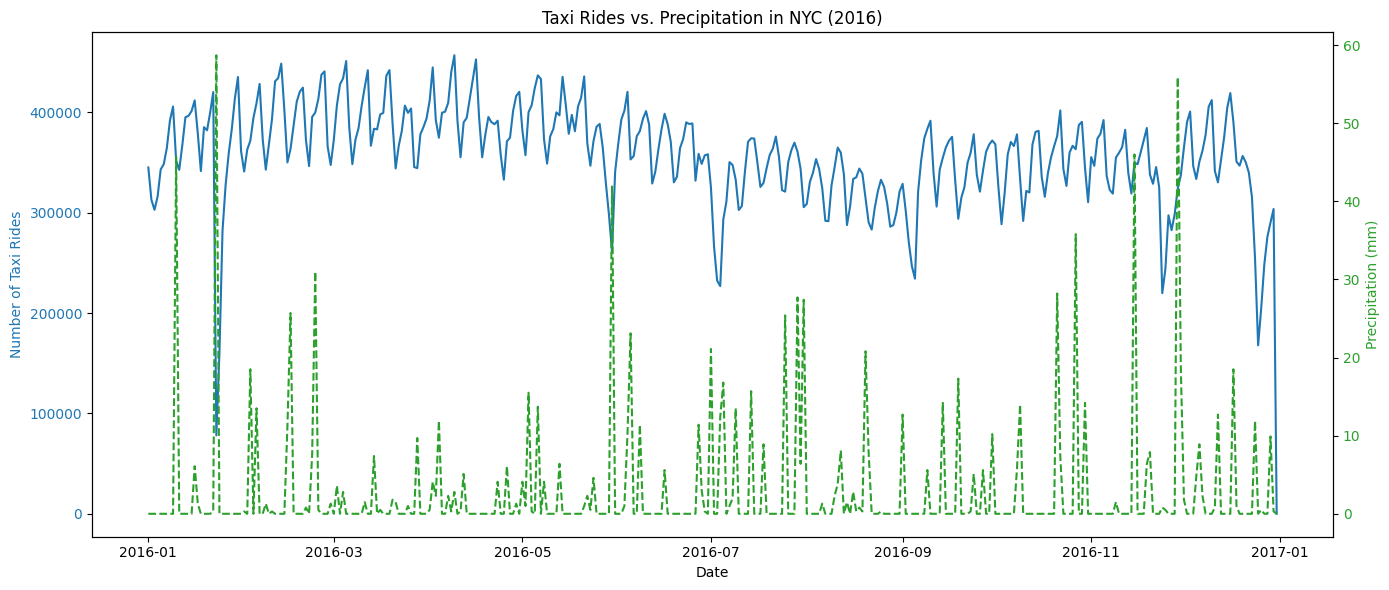

In [31]:
# Plot number of taxi rides and precipitation over time with dual y-axes
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot taxi rides on left y-axis
ax1.set_xlabel("Date")
ax1.set_ylabel("Number of Taxi Rides", color="tab:blue")
ax1.plot(combined_df['date'], combined_df['num_rides'], color="tab:blue", label="Taxi Rides")
ax1.tick_params(axis='y', labelcolor="tab:blue")

# Create a second y-axis sharing the same x-axis for precipitation
ax2 = ax1.twinx()
ax2.set_ylabel("Precipitation (mm)", color="tab:green")
ax2.plot(combined_df['date'], combined_df['PRCP'], color="tab:green", linestyle="--", label="Precipitation")
ax2.tick_params(axis='y', labelcolor="tab:green")

# Set plot title and adjust layout
plt.title("Taxi Rides vs. Precipitation in NYC (2016)")
fig.tight_layout()
plt.show()


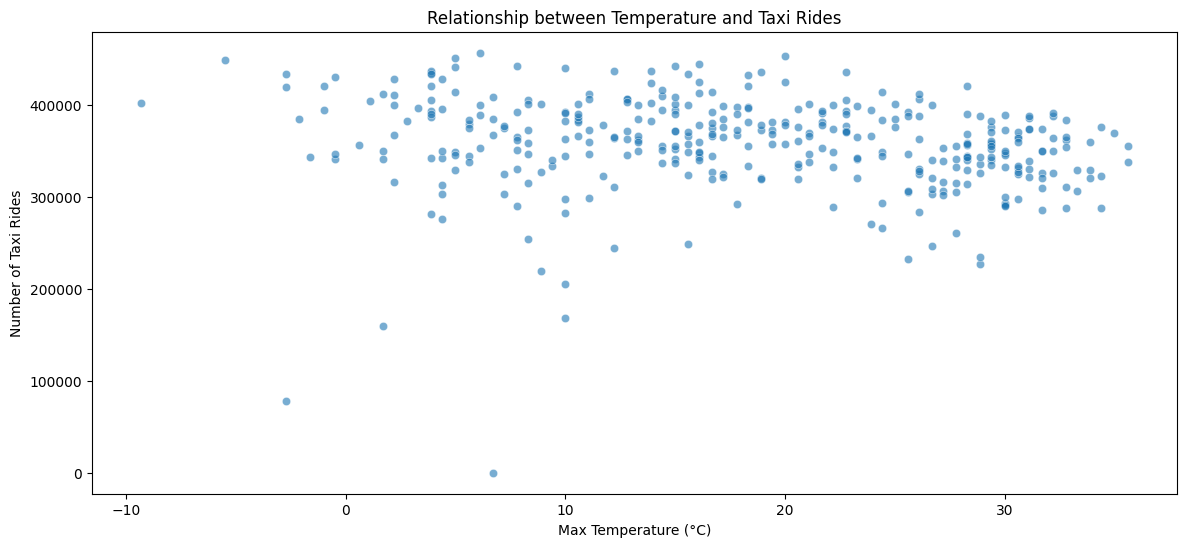

In [32]:
# Scatter plot to visualize relationship between max temperature and number of taxi rides
plt.figure(figsize=(14, 6))
sns.scatterplot(data=combined_df, x='TMAX', y='num_rides', alpha=0.6)
plt.title("Relationship between Temperature and Taxi Rides")
plt.xlabel("Max Temperature (°C)")
plt.ylabel("Number of Taxi Rides")
plt.show()


## Q5: How can drivers earn more tips?

In this section, we investigate the key factors that may influence the amount of tips received by taxi drivers. We focus on five variables:

- Trip distance
- Hour of the day
- Trip duration
- Day of the week

Our goal is to identify patterns that help drivers understand when and how they can maximize their tips.

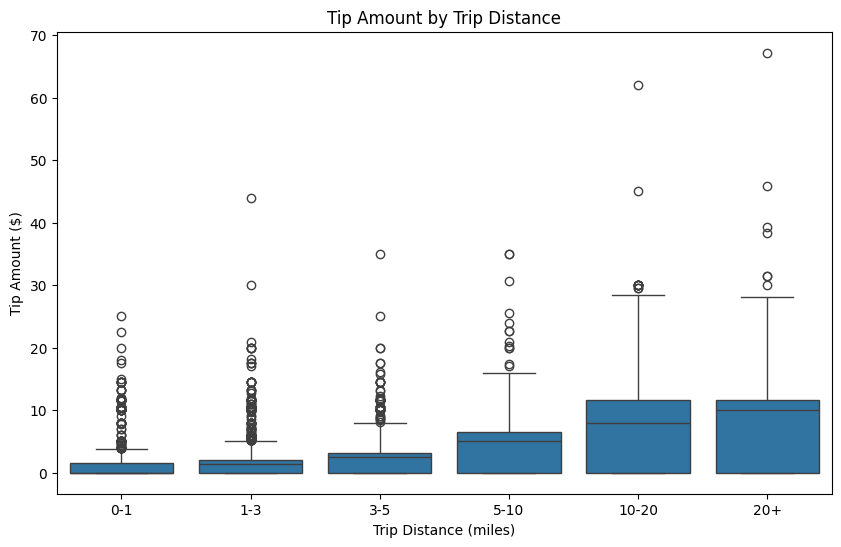

In [33]:
# Tip vs Trip Distance
df['distance_bin'] = pd.cut(df['trip_distance'], bins=[0, 1, 3, 5, 10, 20, 50], labels=['0-1','1-3','3-5','5-10','10-20','20+'])

plt.figure(figsize=(10,6))
sns.boxplot(x='distance_bin', y='tip_amount', data=df)
plt.title("Tip Amount by Trip Distance")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Tip Amount ($)")
plt.show()

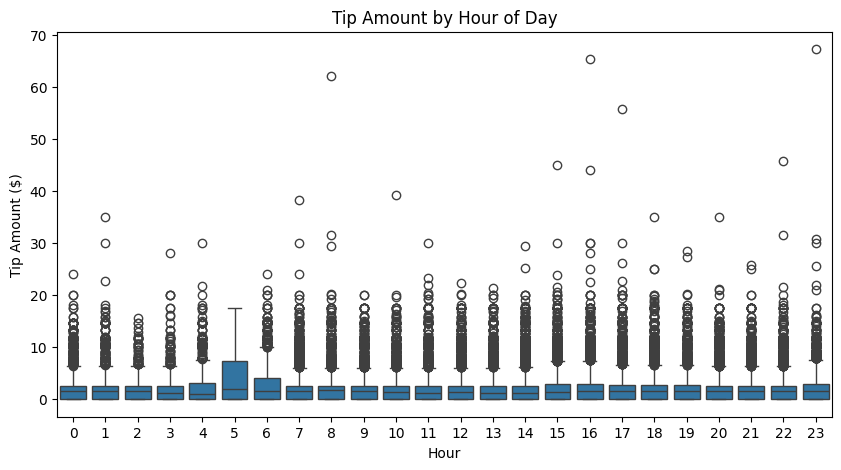

In [34]:
# Tip vs Hour of Day
df['hour'] = df['pickup_datetime'].dt.hour

plt.figure(figsize=(10,5))
sns.boxplot(x='hour', y='tip_amount', data=df)
plt.title("Tip Amount by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Tip Amount ($)")
plt.show()


/tmp/ipython-input-35-208284368.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['duration_bin'] = pd.cut(df['trip_duration_min'], bins=[0,5,10,15,30,60,120,180], labels=['0-5','5-10','10-15','15-30','30-60','60-120','120-180'])


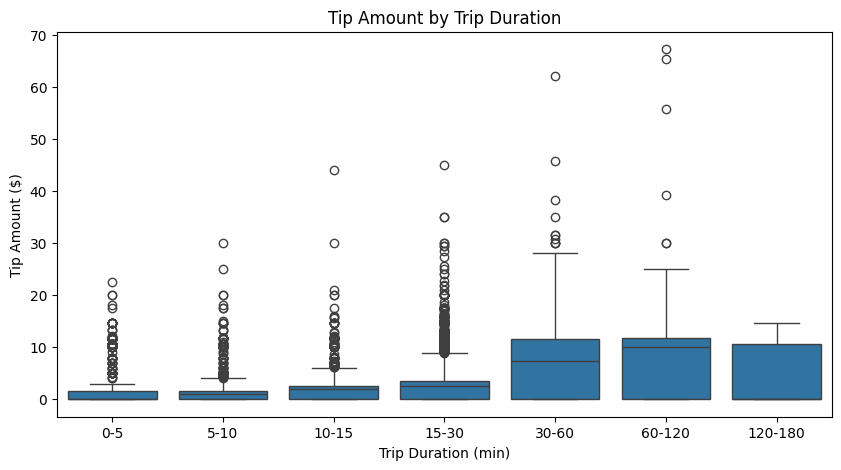

In [35]:
# Tip vs Trip Duration
df['trip_duration_min'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60
df = df[df['trip_duration_min'] < 180]  # remove extreme values

# Binning
df['duration_bin'] = pd.cut(df['trip_duration_min'], bins=[0,5,10,15,30,60,120,180], labels=['0-5','5-10','10-15','15-30','30-60','60-120','120-180'])

plt.figure(figsize=(10,5))
sns.boxplot(x='duration_bin', y='tip_amount', data=df)
plt.title("Tip Amount by Trip Duration")
plt.xlabel("Trip Duration (min)")
plt.ylabel("Tip Amount ($)")
plt.show()

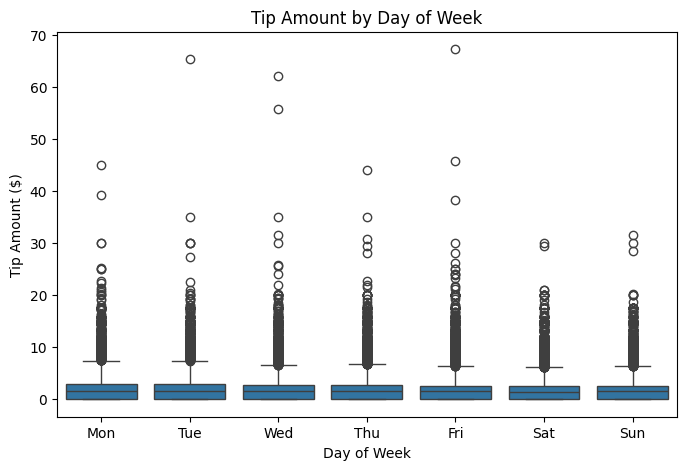

In [36]:
# Tip vs Day of Week
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek  # 0=Monday, 6=Sunday
weekday_map = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
df['day_str'] = df['day_of_week'].map(weekday_map)

plt.figure(figsize=(8,5))
sns.boxplot(x='day_str', y='tip_amount', data=df, order=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.title("Tip Amount by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Tip Amount ($)")
plt.show()

# 4. Summary

## Q1: How does the number of taxi rides vary over time of day?
Ride volume is lowest in the early morning hours (around 4–6 AM), then increases sharply during the morning commute (7–9 AM). Activity remains steady throughout the afternoon and peaks in the evening, with the highest number of rides occurring between 6 PM and 8 PM. After 9 PM, the number of rides gradually decreases.

This pattern suggests that demand is highest during evening hours, likely due to people commuting home, attending events, or going out for leisure. Drivers aiming to maximize their trip count should consider working during late afternoons and early evenings.

## Q2: What types of trips are common?
The majority of trips tend to be short and medium distance, indicating most passengers take relatively brief rides.

## Q3: Are short or long trips better for drivers?
Long trips generally bring higher total fares and tips per ride, which can increase driver earnings per trip. However, short trips may allow drivers to complete more rides in a shorter time, potentially increasing overall income through volume. The balance depends on factors like traffic, wait times, and fare structure, but typically, long trips yield higher earnings per trip while short trips might offer more frequent earning opportunities.

## Q4: Can the weather explain changes in taxi activity?
Generally, heavier rainfall corresponds to increased taxi usage, likely because people avoid walking or using public transport in wet conditions. However, the data also shows that during extremely heavy rain, the number of taxi rides can drop significantly, possibly due to unsafe driving conditions or fewer people traveling overall. Similarly, extreme temperatures (very cold or very hot) can also influence the number of rides, showing that weather conditions do have a noticeable impact on taxi demand.

## Q5: How can drivers earn more tips?
Focus on Longer Trips: While the first image shows a wide range of trip distances, longer trips (e.g.,60-120 minutes) in the "Tip Amount by Trip Duration" graph tend to have higher tip amounts. Drivers may earn more by accepting or prioritizing longer rides.

Work During Peak Hours: The "Tip Amount by Hour of Day" graph indicates that tips are higher during certain hours, likely corresponding to rush hours or late-night times when demand is high. Drivers can maximize earnings by working during these peak hours (e.g., early morning, midday, or evening).

